In [12]:
import numpy as np
from PIL import Image as im
from PIL import ImageEnhance as ime
from PIL import ImageOps as imo
from numpy.lib.stride_tricks import sliding_window_view

from scipy.ndimage import convolve1d
from scipy.signal import firwin, welch

In [2]:
def rot(old_coord):
    # Input: Last relative coordinate
    # Output: Next relative coordinate
    last = old_coord
    if   (last == (-1,-1)):
        return    (-1, 0)
    elif (last == (-1, 0)):
        return    (-1, 1)
    elif (last == (-1, 1)):
        return    (0, 1)
    elif (last == (0, 1)):
        return    (1, 1)
    elif (last == (1, 1)):
        return    (1, 0)
    elif (last == (1, 0)):
        return    (1, -1)
    elif (last == (1, -1)):
        return    (0, -1)
    else:
        return    (-1, -1)

In [3]:
def next_coord(coord, edges, last_coord):
    # Input: x,y coordinate of current pixel
    #        set of all edges
    #        last pixel seen
    # Output: next pixel in clockwise order
    (y,x) = coord
    (last_y, last_x) = last_coord
    rel_coord = (last_y - y, last_x - x)
    for _ in range(8): # Was 7
        (diff_y, diff_x) = rot(rel_coord)
        if (tuple([y + diff_y, x + diff_x]) in edges): #true if an edge
            return (y + diff_y, x + diff_x)
        rel_coord = (diff_y, diff_x)
    return None

In [4]:
def outline(start, edges):
    # Input: start edge, possible connecting edges
    # Output of the pixels on the border of image
    # in clockwise order
    (y,x) = start
    last = (0,0)
    (offset_y, offset_x) = (1, 0)
    last = (y+offset_y, x+offset_x)
    
    #ToDO Find the side that has white on it
        
    next_ = next_coord(start, edges, last) # wrong
    # better way to correct for next_
    
    
    last = start
    border = [start]
    border_set = set(start)
    while(True):
        if (next_ == None or next_ == start):#or next_ in border_set):
            break
        else:
            border.append(next_)
            border_set.add(next_)
            new_next = next_coord(next_, edges, last)
            last = next_
            next_ = new_next
    #print(border)      
    return border

In [5]:
def plot_borders(borders, size):
    temp = np.zeros(shape=size)
    for border in borders:
        for (y,x) in border:
            temp[y,x] = 255

    temp = temp.astype(np.uint8)
    img = im.fromarray(temp)
    display(img)

In [6]:
def remove_lines(image, distortion_freq=None, num_taps=65, eps=0.025):
  """Removes horizontal line artifacts from scanned image.
  Args:
    image: 2D or 3D array.
    distortion_freq: Float, distortion frequency in cycles/pixel, or
      `None` to estimate from spectrum.
    num_taps: Integer, number of filter taps to use in each dimension.
    eps: Small positive param to adjust filters cutoffs (cycles/pixel).
  Returns:
    Denoised image.
  """
  image = np.asarray(image, float)
  if distortion_freq is None:
    distortion_freq = estimate_distortion_freq(image)

  hpf = firwin(num_taps, distortion_freq - eps,
               pass_zero='highpass', fs=1)
  lpf = firwin(num_taps, eps, pass_zero='lowpass', fs=1)
  return image - convolve1d(convolve1d(image, hpf, axis=0), lpf, axis=1)

In [7]:
def estimate_distortion_freq(image, min_frequency=1/25):
  """Estimates distortion frequency as spectral peak in vertical dim."""
  f, pxx = welch(np.reshape(image, (len(image), -1), 'C').sum(axis=1))
  pxx[f < min_frequency] = 0.0
  return f[pxx.argmax()]

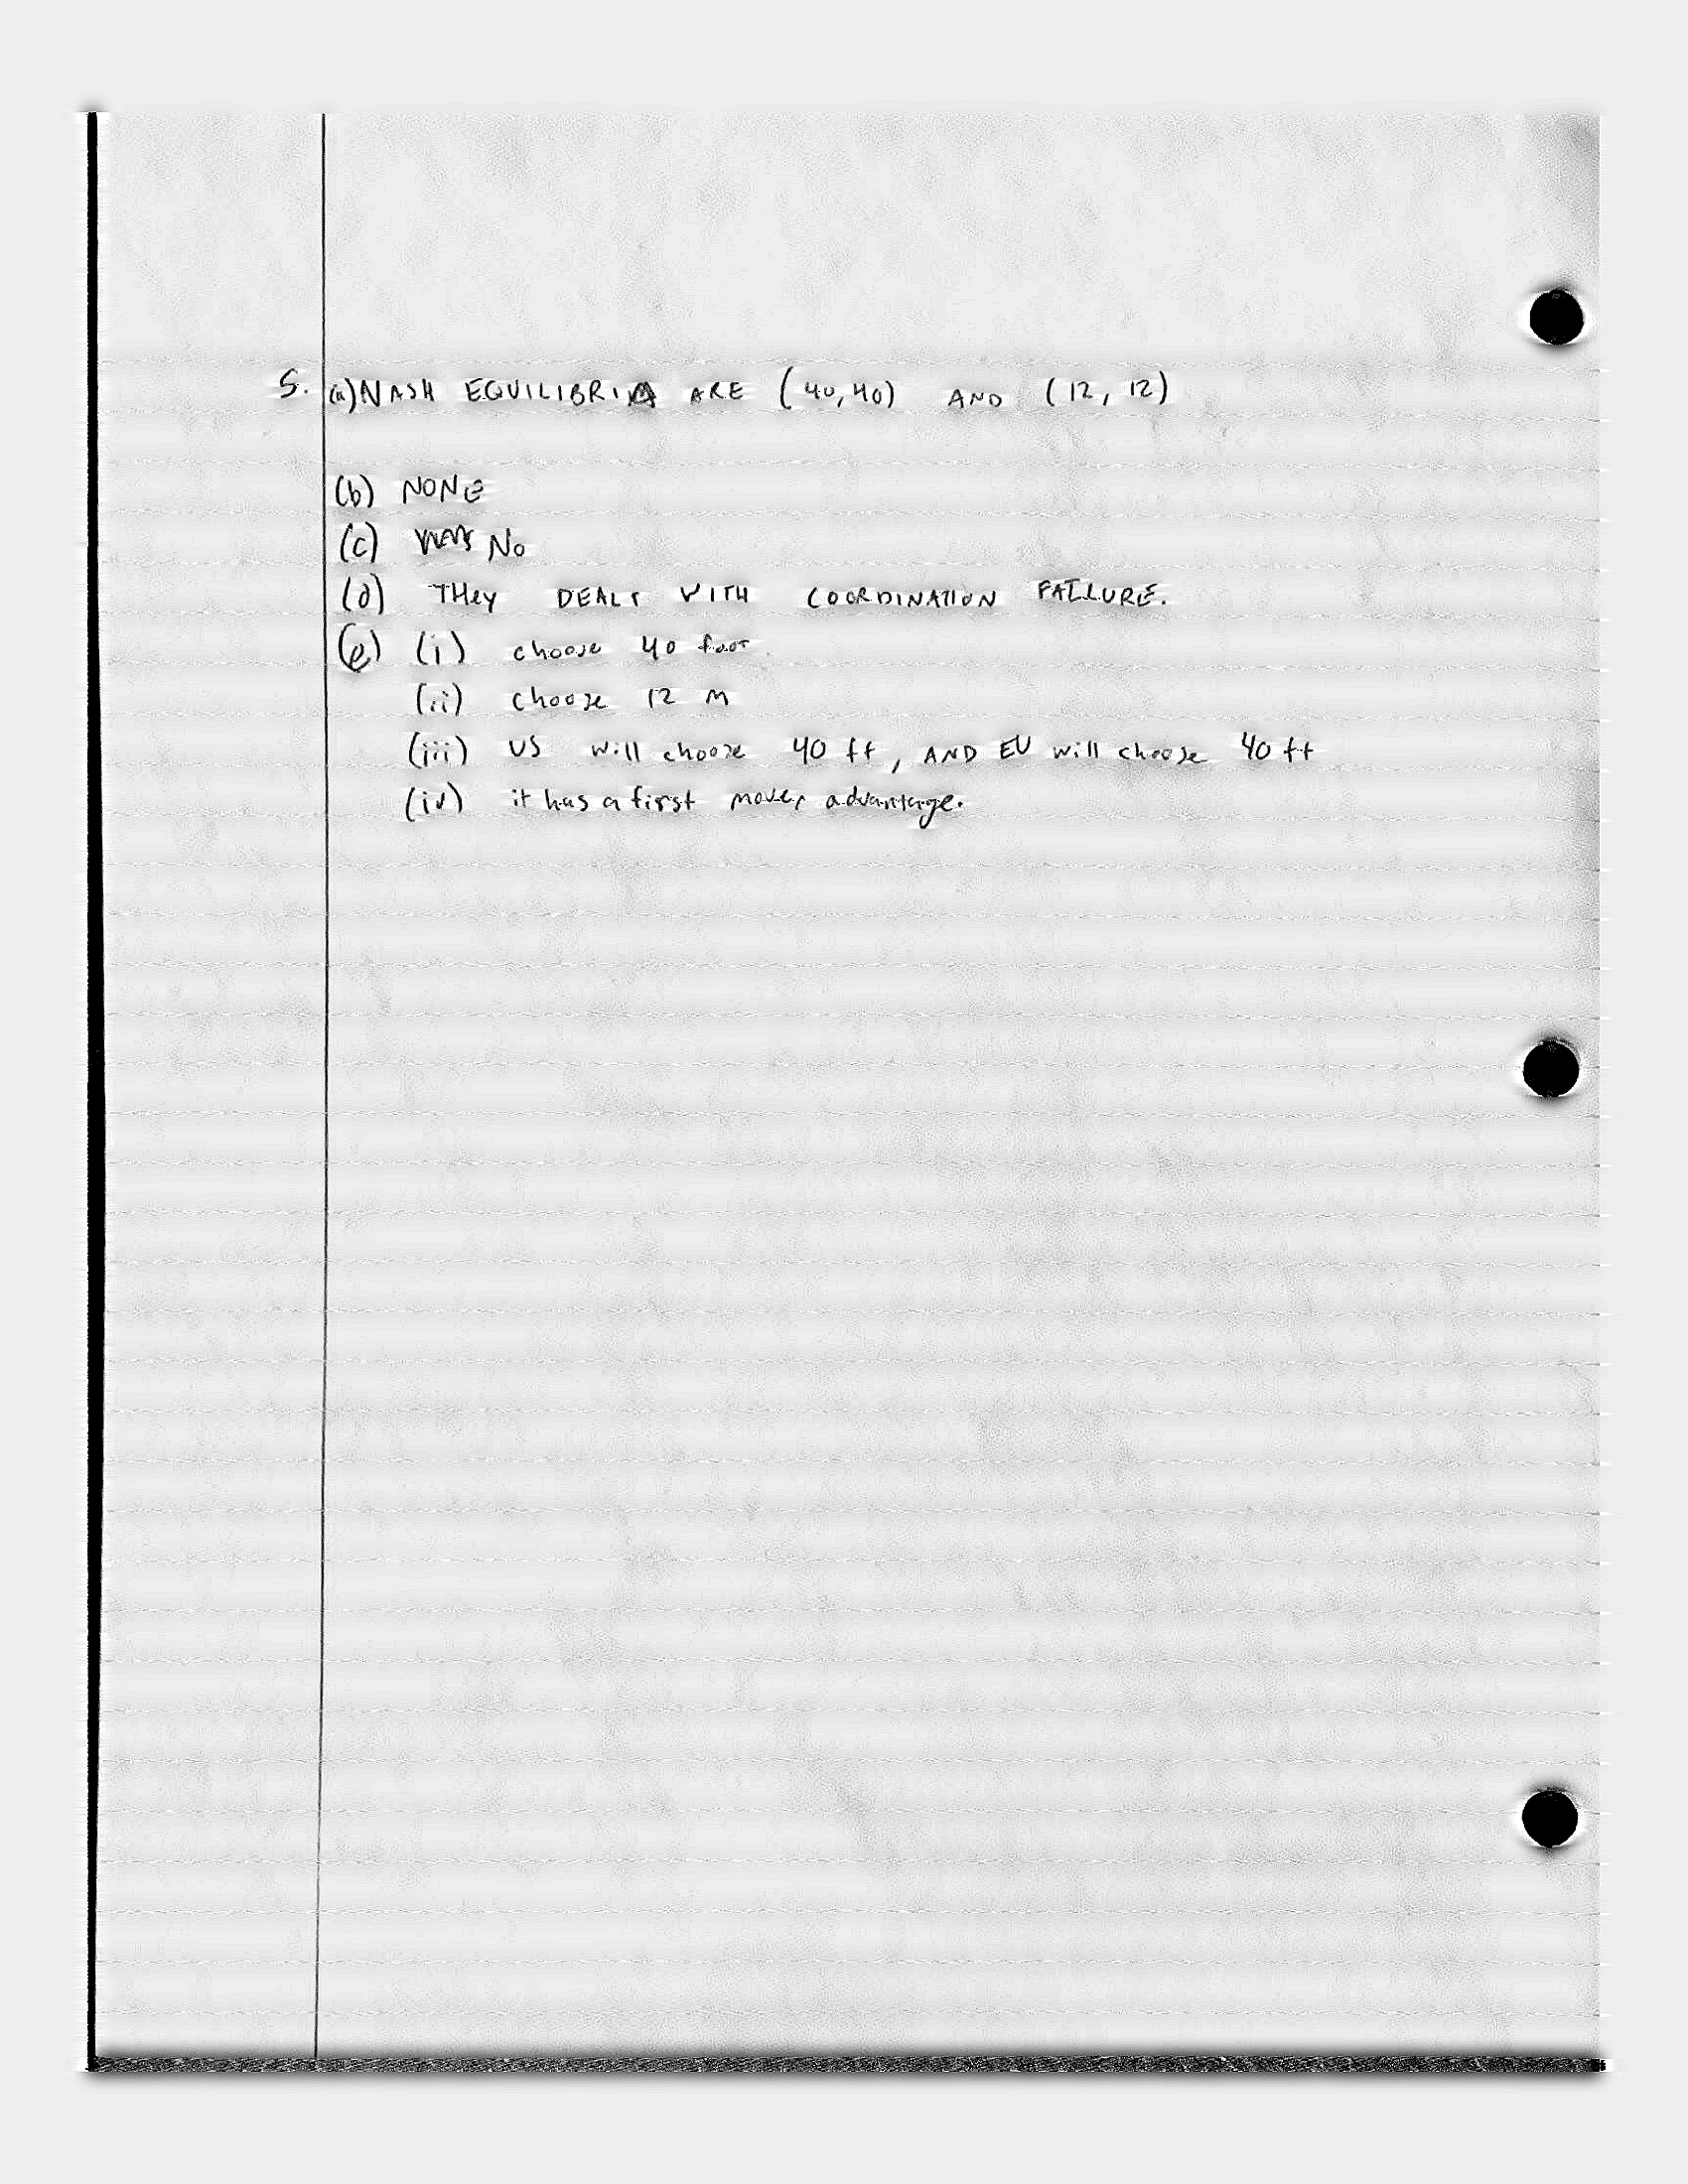

In [59]:
name = "6"
figure_img = im.open(f"imgs/test_document-{name}.png")
#figure_img = im.open("imgs/macro_images/a.JPG")

figure_img = imo.grayscale(figure_img)
img = np.asarray(figure_img)
#new_img = img
new_img = remove_lines(img)
img = im.fromarray(np.uint8(new_img), 'L')

# Increase the Contrast
enhancer = ime.Contrast(img)
factor = 3 #gives original image
im_output = enhancer.enhance(factor)
enhancer = ime.Sharpness(im_output)
factor = 3 #gives original image
im_output = enhancer.enhance(factor)

display(im_output)

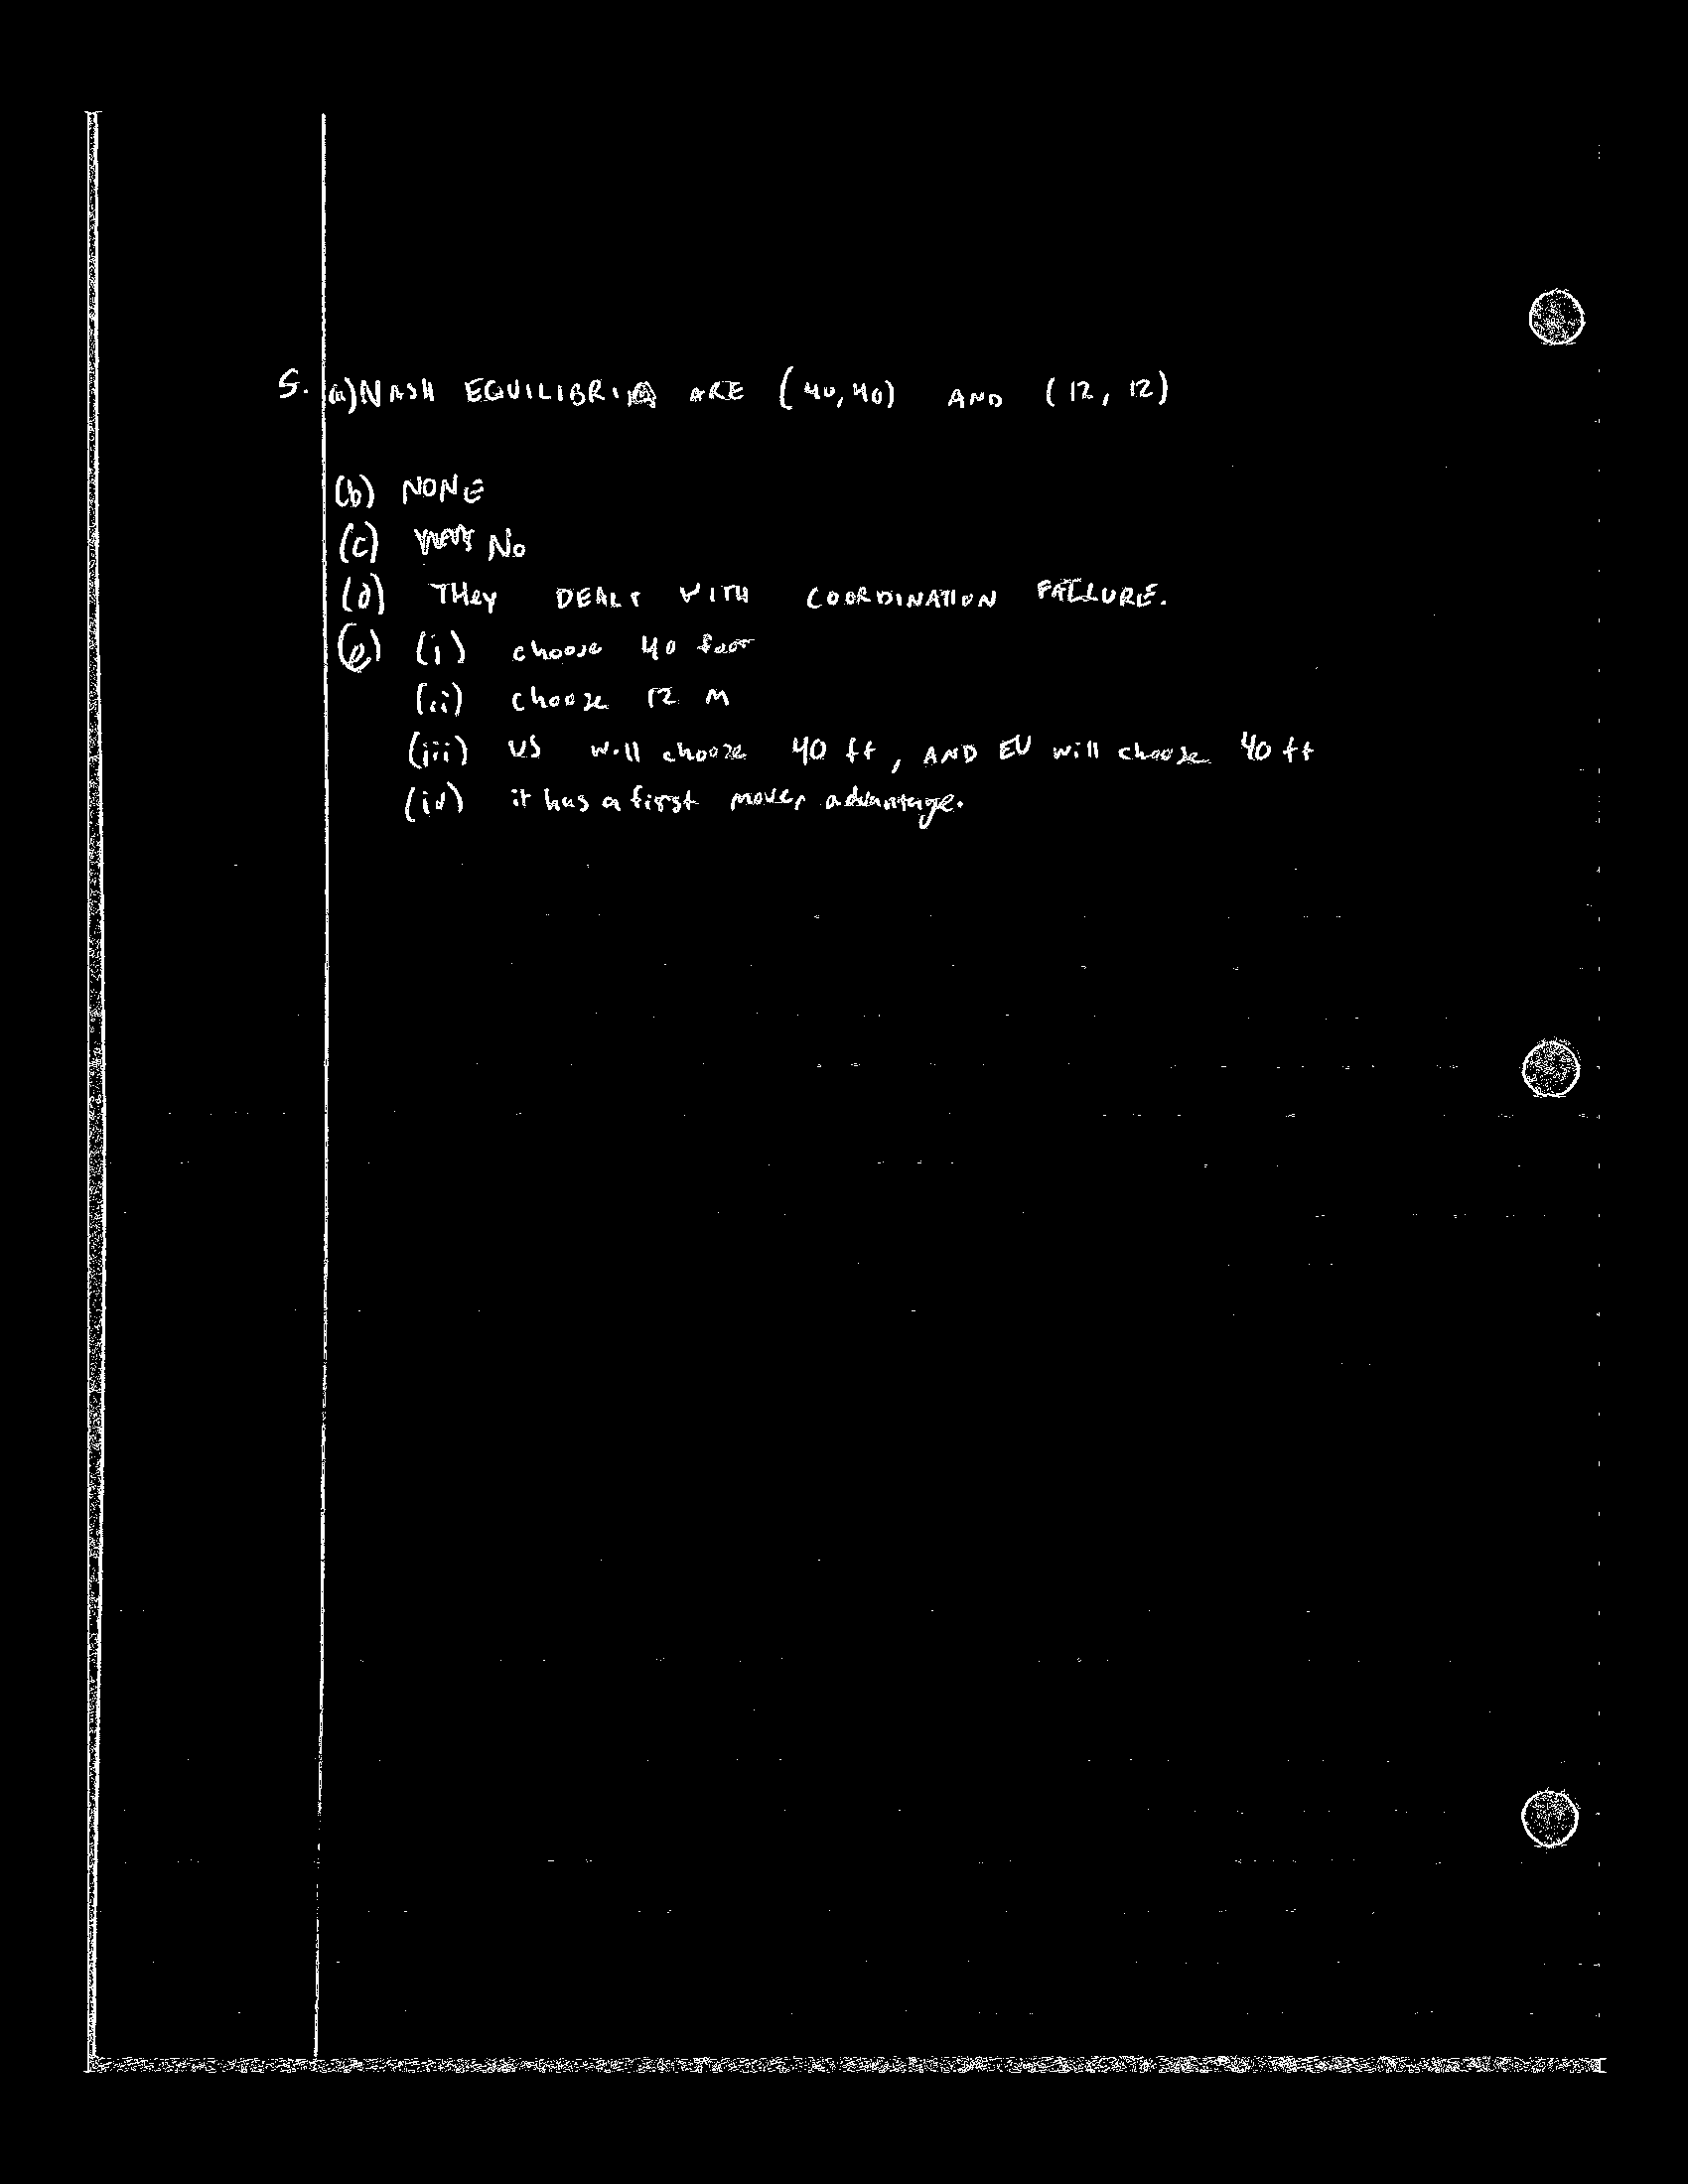

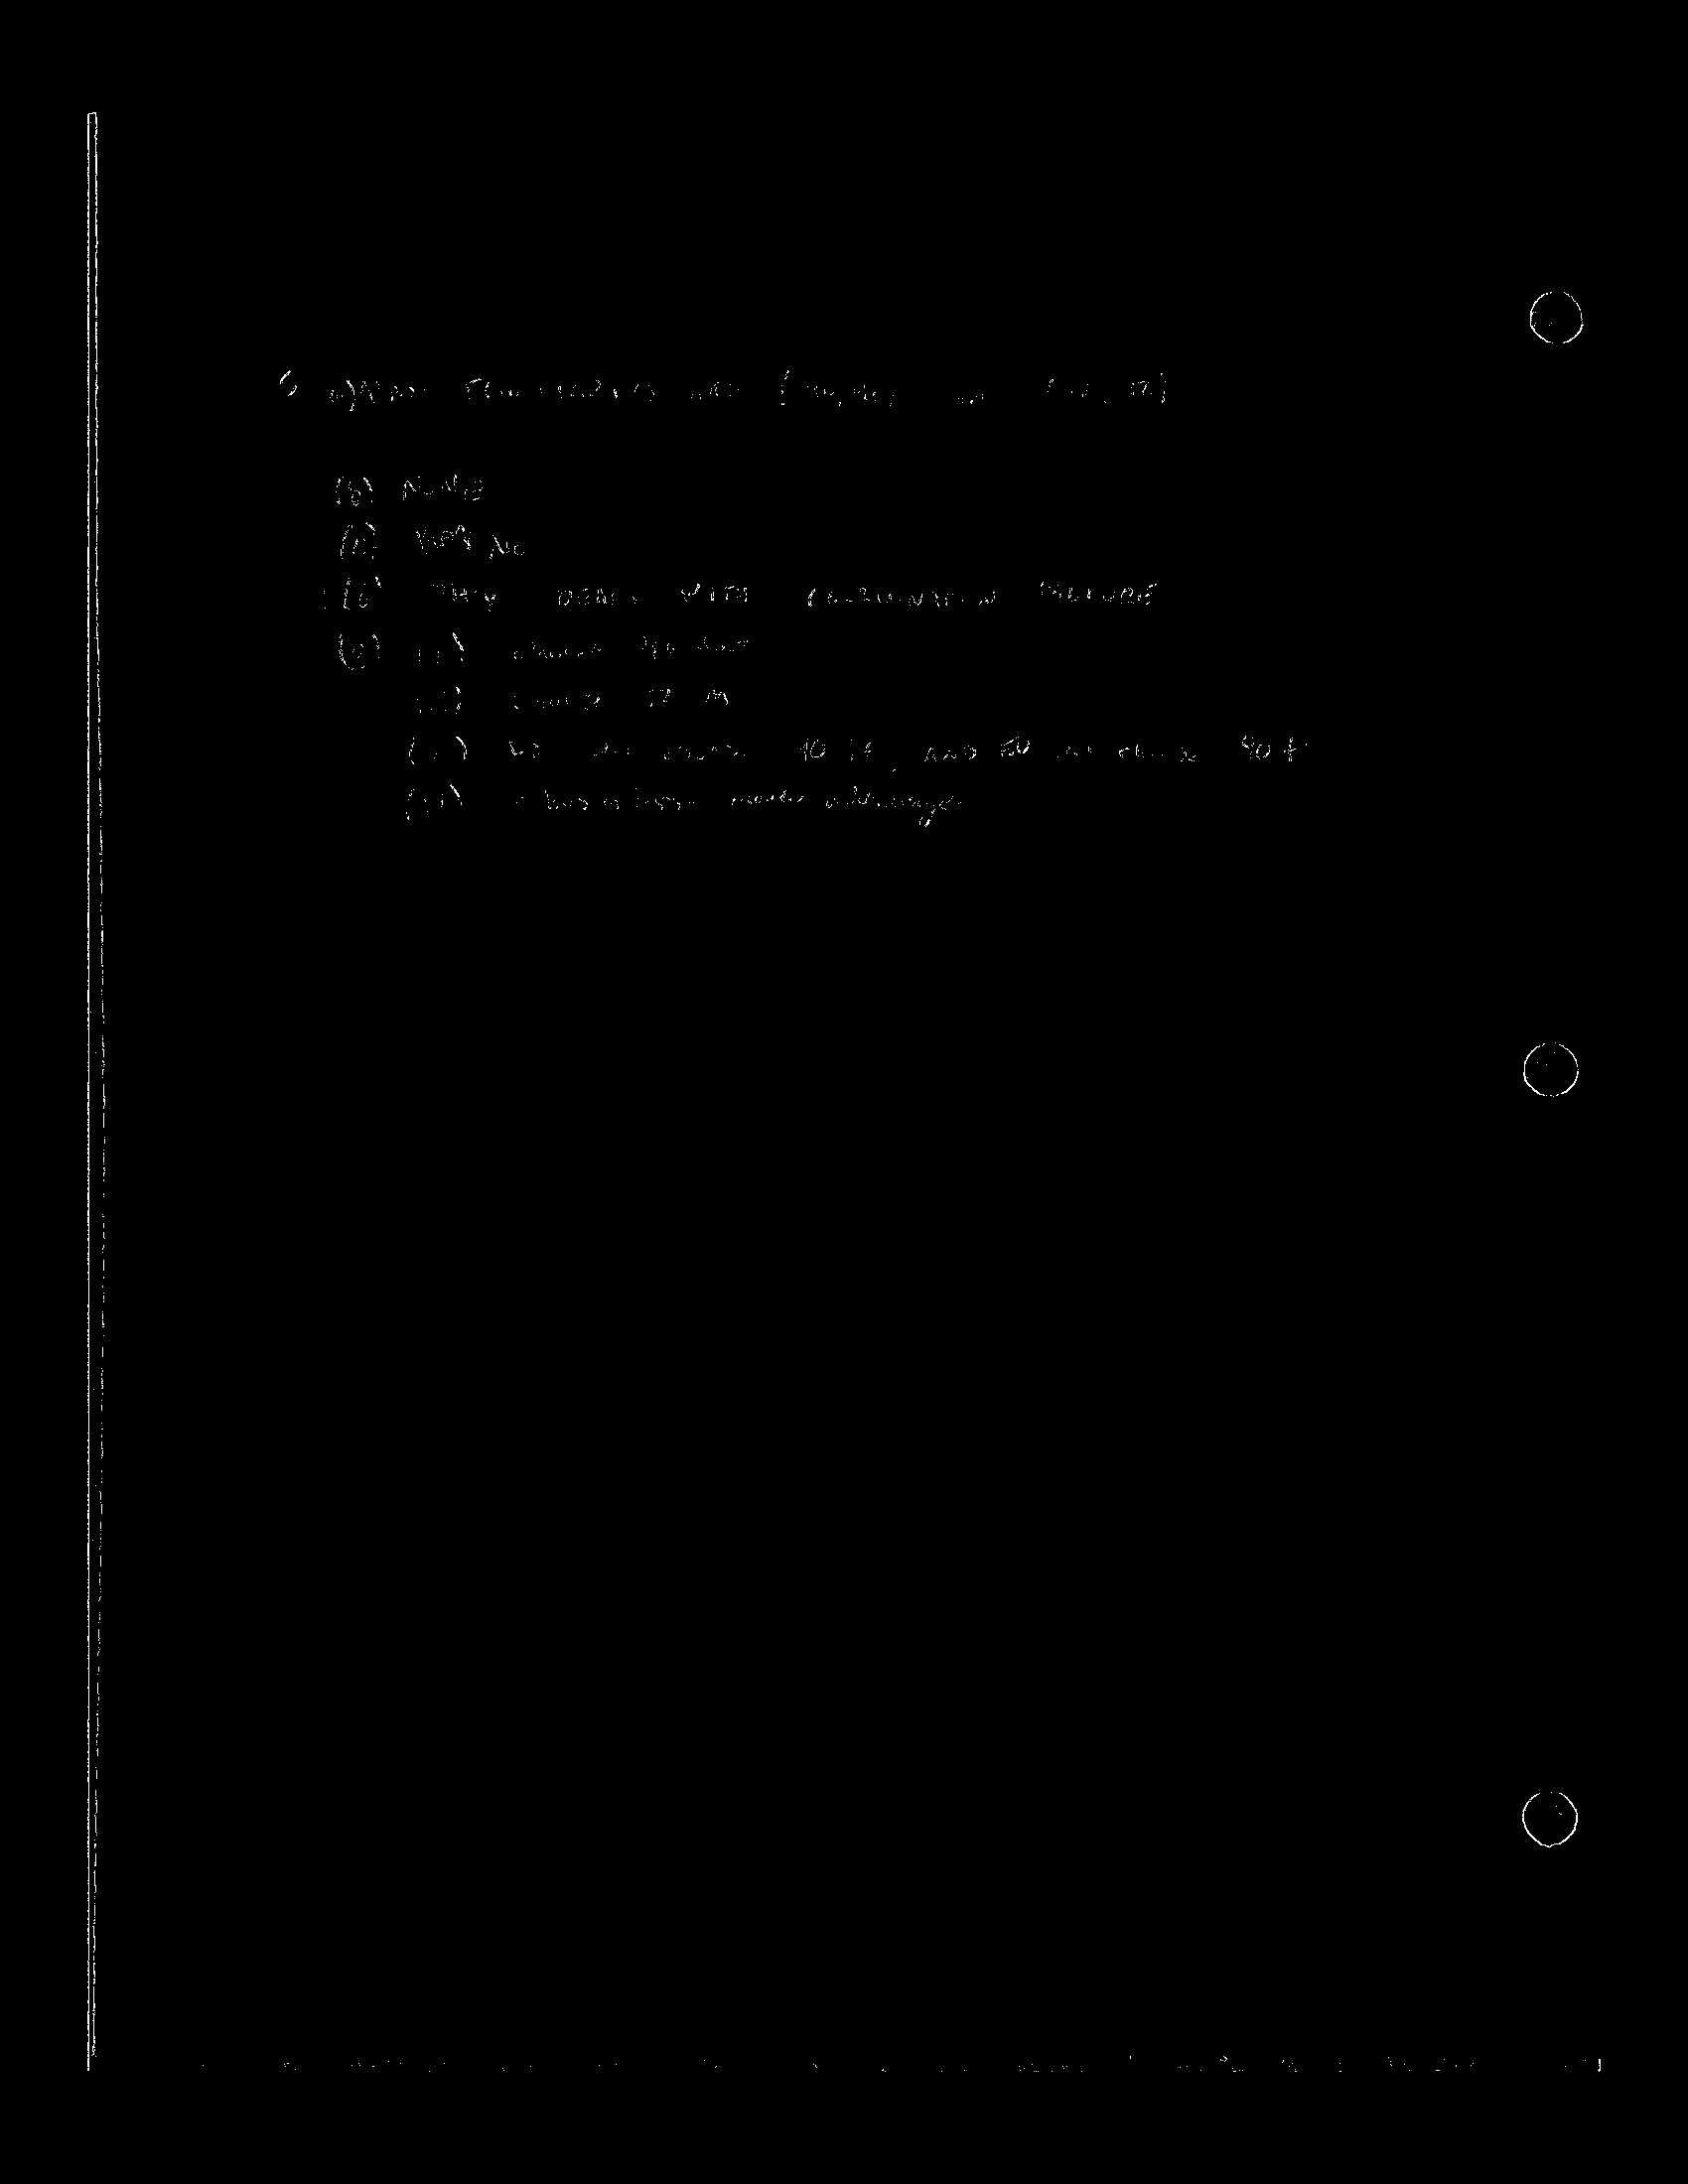

In [60]:
# All Edges
figure =  np.asarray(new_img) / 255
pixels = sliding_window_view(figure, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(edges,figure,out=edges)
np.greater_equal(edges, 0.07, out=edges) # contrast
img = im.fromarray(np.uint8(edges * 255), 'L')
display(img)

# Critical Edges
pixels = sliding_window_view(figure, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
crit_edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(crit_edges,figure,out=crit_edges)
np.greater_equal(crit_edges, 0.2, out=crit_edges) # contrast
img = im.fromarray(np.uint8(crit_edges * 255), 'L')
display(img)

In [64]:
# BLUR
# n = 3 #odd number
# pixels = sliding_window_view(edges, (n,n))
# number_of_pixels = pixels.shape[0] * pixels.shape[1]
# shape = (pixels.shape[0], pixels.shape[1])
# blur = np.reshape(pixels, (number_of_pixels,n**2)).max(axis=-1).reshape(shape)
# blur = np.pad(blur, pad_width=1, mode='constant')
# img = im.fromarray(np.uint8(blur * 255), 'L')
# display(img)
#kernel = np.array([1.0,2.0,1.0]) # Here you would insert your actual kernel of any size
kernel = np.array([[1.0,2.0,1.0], [2.0,4.0,2.0], [1.0,2.0,1.0]])
kernel = kernel / np.sum(kernel)
blur = np.apply_along_axis(lambda x: np.convolve1d(x, kernel, mode='same'), 0, edges)
blur= np.apply_along_axis(lambda x: np.convolve1d(x, kernel, mode='same'), 1, blur)
img = im.fromarray(np.uint8(blur * 255), 'L')
display(img)

# Critical Edges
pixels = sliding_window_view(blur, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
blur_edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(blur_edges,blur,out=blur_edges)
np.greater_equal(blur_edges, 0.01, out=blur_edges) # contrast
img = im.fromarray(np.uint8(blur_edges * 255), 'L')
display(img)
print(np.count_nonzero(blur == 1))
print(np.count_nonzero(blur_edges == 1))

AttributeError: module 'numpy' has no attribute 'convolve1d'